In [34]:
import numpy as np
import scipy.signal
import sounddevice as sd
%matplotlib inline
from pylab import *
import matplotlib.figure
import itertools
import random
import mpld3
from scipy import stats
mpld3.enable_notebook()
rcParams['figure.figsize'] = 10, 6
rcParams['figure.dpi'] = 90

## Transmitting

First, we take text input and convert the file into binary and fit the binary elementwise into a numpy array; this signal is later going to be modulated into something we can play on our speakers.

In [102]:
with open ("test.txt", "r") as myfile:
    data=myfile.readlines()
data = np.array(data)
signal = np.array([],"uint8")
for d in data:
    for char in d:
        binary = bin(ord(char))[2:]
        if len(binary) < 8:
            binary = "0" * (8-len(binary)) + binary
        signal = np.append(signal, [int(b) for b in binary])
print(signal.shape)

(96,)


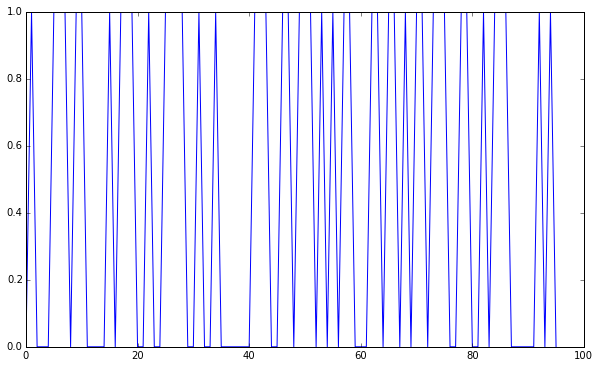

In [103]:
plt.plot(signal)

In [104]:
def pad(data, padding):
    data = np.concatenate([padding, data])
    data = np.concatenate([data, padding])
    return data

In this step, we want to add a barker code to the beginning of our signal to tell our receiver where the beginning of our message is. This code basically signals the beginning  of our file and is difficult to reproduce with noise. In addition, we added 40 zeros on either side after noticing the signal was being cut off on the receiver end.

In [105]:
barker=[1,1,1,0,0,0,1,0,0,1,0]
signal = np.append(barker, signal)
signal = pad(signal, np.zeros(40))
signal[signal == 0] = -1

##Modulation

Our implementation essentially relies on quickly shifting between 2 frequencies to send values of "1" and "0". Getting this right was the most time-consuming part of our project, and we wrote two separate modulation implementations: GFSK and FSK. When GFSK seemed to be creating fairly abysmal accuracy rates, we tried FSK and saw noticeable improvements.

###Roadblocks:
First off, our first implementation, GFSK, didn't work, the remnants of which you see below. We looked for alternate solutions and wrote and implementation of FSK that seemed to work a lot better.

In addition, a large factor in our accuracy were tuning the parameters (both here and on the receiving end). Some of the major parameters we considered included carrier frequency, modulation index, sample rate, and bit_rate. We quickly found that achieving a high accuracy on very low bit_rates was easy, but as we increased bit_rate all of our other parameters had to change. We raised carrier frequency and looked at the fourier transform plots of different signals to identify the best range to vary frequencies, as well as frequencies we could use to create a band pass filter to lessen noise (more on that in the receiver write-up).

We also experienced difficulties with sampling, and had to write numerous workarounds including fixes to rounding errors as well as choosing accurate thresholds (what part of a wave to consider a zero or one). We often found we were sampling a point more than once or missing values we could see were a "0" in our final wave form but the computer didn't pick up on.

In [107]:
def gauss_imp(BT, span, sample_rate):
    #num_coefficients is the sampling rate of the filter
    #3db_bandwidth is the 3db bandwidth of the gaussian filter
    #symbol time is the time difference between two symbols during transmission
    alph = np.sqrt(2. * np.pi / np.log(2)) * BT
    imp = np.linspace(- span * sample_rate / 2, span * sample_rate / 2, span*sample_rate)
    #generate coefficents
    imp *= np.sqrt(np.pi) * alph / sample_rate
    imp = - np.power(imp, 2)
    imp = np.exp(imp)
    imp *= alph
    imp /= sum(imp)
    return imp

def convolve(data, imp):
    out = []
    for a in range(len(data)):
        count = 0
        for i in range(len(imp)):
            if a - i >= 0:
                count += imp[i] * data[a - i]
        out.append(count)
    return np.array(out)

def GFSK_mod(carrier_freq, mod_index, mod_sample_rate, data, bit_rate, BT, span):
    total_time = len(data) / bit_rate
    
    time = np.linspace(0, total_time, total_time * mod_sample_rate)
    
    bit_span = mod_sample_rate/bit_rate
    
    sampled_data = np.repeat(data, bit_span)
    
    imp = gauss_imp(BT, span, bit_span)
    
    filtered_data = scipy.signal.convolve(sampled_data, imp, mode='same')
    
    
    plt.figure()
    plt.plot(filtered_data)
    plt.plot(sampled_data)
    plt.title('Filtered Data')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (V)')
    plt.show()
    
    return time, np.cos(2 * np.pi * carrier_freq * time + mod_index * filtered_data)

def FSK_mod(carrier_freq, freq_dev, mod_sample_rate, data, bit_rate):
    total_time = len(data) / bit_rate
    
    time = np.linspace(0, total_time, total_time * mod_sample_rate)
    
    bit_span = mod_sample_rate/bit_rate
    
    sampled_data = np.repeat(data, bit_span)
    
    return time, np.cos(2 * np.pi * carrier_freq * time + 2 * np.pi * freq_dev * sampled_data * time)

def transmit(signal):
    # signal is an np.array of the signal we are playing
    frames_per_second = 48000
    sd.play(data = signal, samplerate = fs, blocking = False)

Here, we sampled at 44100 Hz and used a carrier frequency of 1800 Hz. Our bit_rate is at the minimum 100 bits/second.

In [108]:
INPUT_SAMPLE_RATE = 44100
_, test_signal = FSK_mod(1800, 600, INPUT_SAMPLE_RATE, signal, 100)

In [94]:
sd.play(test_signal, samplerate = INPUT_SAMPLE_RATE, blocking=True)

For the sake of clarity, here's a close-up of the signal we're sending, at the transition point of our two frequencies

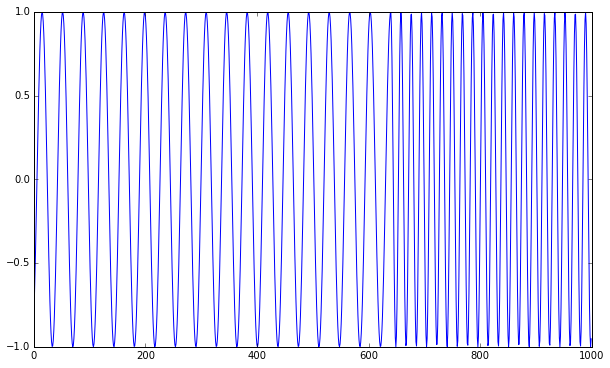

In [114]:
plt.plot(test_signal[17000:18000])